# Face recongnition
In this notebook, we use already trained neural networks for face recognition.

# Download data

Download the data from <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/face_recognition.zip" target="_blank"> face recongnition images</a> and unpack it to the Data folder.

# Import packages

In [6]:
# !pip install pydot

In [4]:
# !pip install mtcnn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import tensorflow as tf

import mtcnn
from PIL import Image

2023-04-25 17:24:03.831595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Detect faces

In [7]:
# extract faces function using mtcnn

def extract_face(filename, required_size=(160, 160), rotate=None, display_img=True):
    image = Image.open(f'./../../Data/face_recognition/{filename}')
    image = image.convert('RGB')
    print(f'Loaded image of shape ({image.size[0]}, {image.size[1]}):')
    pixels = np.asarray(image)
    if display_img:
        plt.imshow(pixels)
        plt.show()
    
    if rotate:
        print(f'Warrning: Rotationg image by {rotate} degrees!')
        image = image.rotate(rotate)
        pixels = np.asarray(image)
        if display_img:
            plt.imshow(pixels)
            plt.show()
        
    detector = mtcnn.MTCNN()
    results = detector.detect_faces(pixels)
    
    n_faces = len(results)
    if n_faces == 1:
        print(f'Face detector discovered {n_faces} face.')
    else:
        print(f'Face detector discovered {n_faces} faces.')
    
    if n_faces == 0:
        return None
    
    if display_img:
        plt.figure(figsize=(20,20))
        plt.imshow(pixels)
    
    for i in range(n_faces-1,-1,-1):
        x1, y1, width, height = results[i]['box']
        x1, y1 = abs(x1), abs(y1)
        x2 = x1 + width
        y2 = y1 + height
        
        if display_img:
            left_eye = results[i]['keypoints']['left_eye']
            right_eye = results[i]['keypoints']['right_eye']
            nose = results[i]['keypoints']['nose']
            mouth_left = results[i]['keypoints']['mouth_left']
            mouth_right = results[i]['keypoints']['mouth_right']
            confidence = results[i]['confidence']

    #         color = (10/255, 134/255, 132/255)
            color='red'
            lw = round(width * 10 / image.size[1])

            plt.plot([x1, x2], [y1, y1], color=color, ls='-', lw=max(3,lw))
            plt.plot([x1, x2], [y2, y2], color=color, ls='-', lw=max(3,lw))
            plt.plot([x1, x1], [y1, y2], color=color, ls='-', lw=max(3,lw))
            plt.plot([x2, x2], [y1, y2], color=color, ls='-', lw=max(3,lw))
            plt.annotate(f'{confidence:.5f}', (x2+10, y1-10), color=color, fontsize=20)

            plt.scatter([left_eye[0], right_eye[0]],[left_eye[1], right_eye[1]], marker='o', s=lw*200, alpha=0.5, color=color)
            plt.scatter([nose[0]],[nose[1]], marker='o', s=lw*200, alpha=0.5, color=color)
            plt.plot([mouth_left[0], mouth_right[0]], [mouth_left[1], mouth_right[1]], color=color, ls='-', lw=lw)
        
    if display_img:
        plt.show()
    
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    if display_img:
        plt.imshow(face_array)
        plt.show()
    return face_array

Loaded image of shape (3264, 2448):


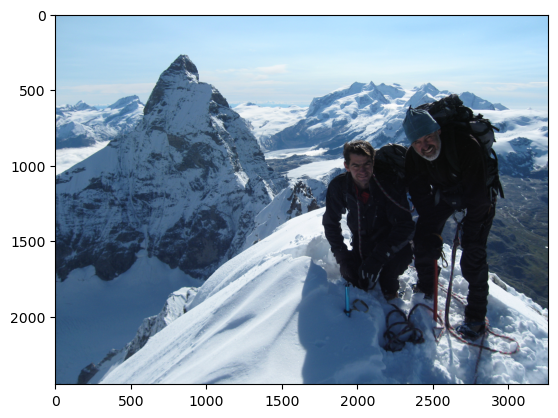

1/1 [==============================] - 0s 129ms/step
Face detector discovered 2 faces.


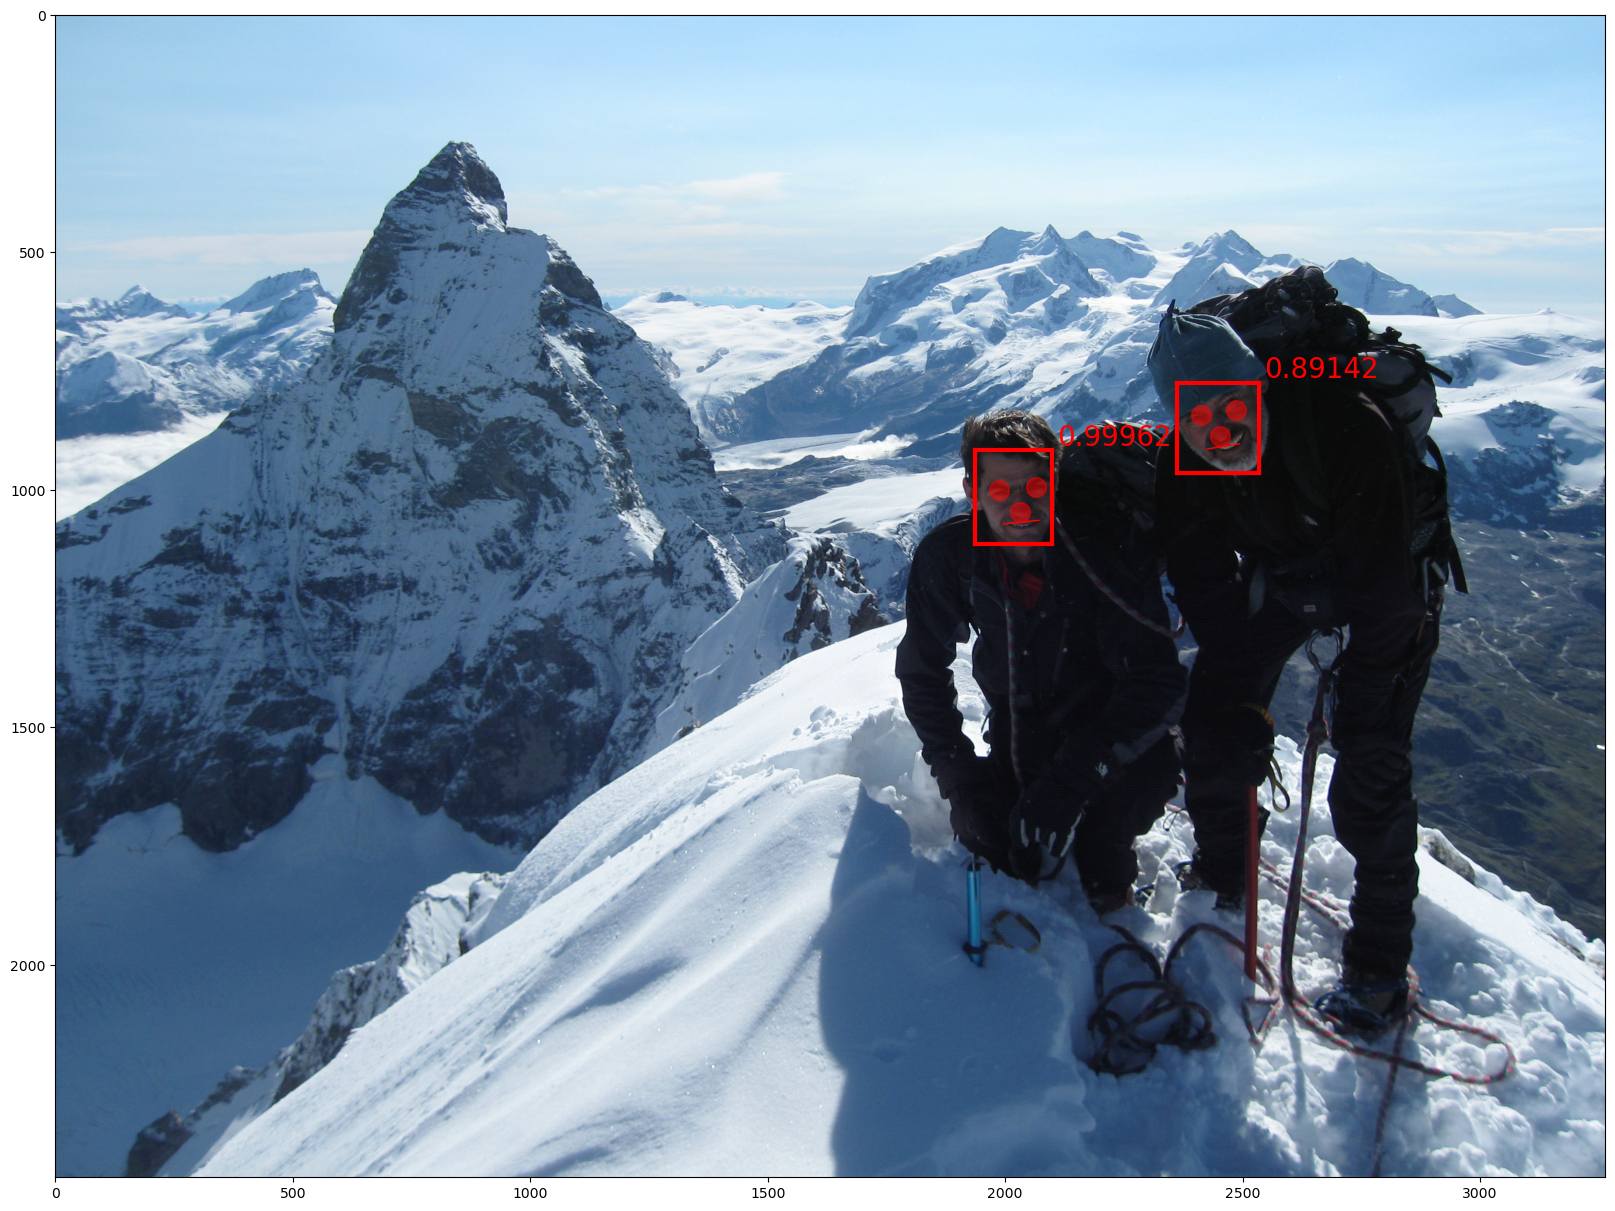

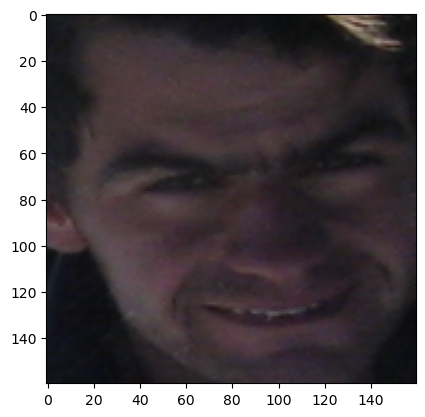

In [10]:
# check one picture

face = extract_face('faces4.jpg', rotate=None, display_img=True)

- Visit https://github.com/nyoki-mtl/keras-facenet/blob/master/code/inception_resnet_v1.py
- download model and weights from https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn
- save it to ./facenet_model

# Encode face in feature space

In [11]:
# copied code, check the InceptionResNet architecture

# -*- coding: utf-8 -*-
"""Inception-ResNet V1 model for Keras.
# Reference
http://arxiv.org/abs/1602.07261
https://github.com/davidsandberg/facenet/blob/master/src/models/inception_resnet_v1.py
https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py
"""
from functools import partial

from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.layers import add
from keras import backend as K


def scaling(x, scale):
    return x * scale


def conv2d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              use_bias=False,
              name=None):
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, momentum=0.995, epsilon=0.001,
                               scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)

    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 32, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 128, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 128, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 192, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 192, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "Block35", "Block17" or "Block8", '
                         'but got: ' + str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name=name_fmt('Conv2d_1x1'))
    up = Lambda(scaling,
                output_shape=K.int_shape(up)[1:],
                arguments={'scale': scale})(up)
    x = add([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV1(input_shape=(160, 160, 3),
                      classes=128,
                      dropout_keep_prob=0.8,
                      weights_path=None):
    inputs = Input(shape=input_shape)
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = conv2d_bn(x, 256, 3, strides=2, padding='valid', name='Conv2d_4b_3x3')

    # 5x Block35 (Inception-ResNet-A block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.17,
                                    block_type='Block35',
                                    block_idx=block_idx)

    # Mixed 6a (Reduction-A block):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 192, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 10x Block17 (Inception-ResNet-B block):
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x,
                                    scale=0.1,
                                    block_type='Block17',
                                    block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,
                         384,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 256, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,
                         256,
                         3,
                         strides=2,
                         padding='valid',
                         name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,
                               strides=2,
                               padding='valid',
                               name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 5x Block8 (Inception-ResNet-C block):
    for block_idx in range(1, 6):
        x = _inception_resnet_block(x,
                                    scale=0.2,
                                    block_type='Block8',
                                    block_idx=block_idx)
    x = _inception_resnet_block(x,
                                scale=1.,
                                activation=None,
                                block_type='Block8',
                                block_idx=6)

    # Classification block
    x = GlobalAveragePooling2D(name='AvgPool')(x)
    x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
    # Bottleneck
    x = Dense(classes, use_bias=False, name='Bottleneck')(x)
    bn_name = _generate_layer_name('BatchNorm', prefix='Bottleneck')
    x = BatchNormalization(momentum=0.995, epsilon=0.001, scale=False,
                           name=bn_name)(x)

    # Create model
    model = Model(inputs, x, name='inception_resnet_v1')
    if weights_path is not None:
        model.load_weights(weights_path)

    return model

model = InceptionResNetV1(weights_path='facenet_model/weights/facenet_keras_weights.h5')

In [12]:
# check the model

model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_7[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [13]:
# plot the model

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
# processing and normalization

from sklearn.preprocessing import Normalizer

images = {
    'face1.jpg': 'Marek',
    'face2.jpg': 'Marek',
    'faces1.jpg': 'Marek',
    'faces4.jpg': 'Marek',
    'face3.jpg': 'Marek\'s father',
    'face6.jpg': 'Marek\'s father',
    'face4.jpg': 'Kuba',
    'face5.jpg': 'Kuba',    
    'faces2.jpg': 'Kuba',
    'faces3.jpg': 'Kiki',
    
}

normalizer = Normalizer(norm='l2')

feat_space = {}
for img, lbl in tqdm(images.items()):
    if img == 'face1.jpg':
        face = extract_face(img, rotate=90, display_img=False)
    else:
        face = extract_face(img, rotate=None, display_img=False)
        
    # normalize face
    face = face.astype('float32')
    mean = face.mean()
    std = face.std()
    face = (face - mean) / std
    
    samples = np.expand_dims(face, axis=0)
    fs = model.predict(samples)
    fs = normalizer.transform(fs)
    feat_space[img] = list(fs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

Loaded image of shape (3296, 1520):
Warrning: Rotationg image by 90 degrees!
1/1 [==============================] - 0s 129ms/step
Face detector discovered 1 face.
1/1 [==============================] - 2s 2s/step
Loaded image of shape (4000, 3000):
1/1 [==============================] - 0s 140ms/step
Face detector discovered 1 face.
1/1 [==============================] - 0s 73ms/step
Loaded image of shape (4000, 3000):
2/2 [==============================] - 0s 13ms/step
Face detector discovered 3 faces.
1/1 [==============================] - 0s 67ms/step
Loaded image of shape (3264, 2448):
1/1 [==============================] - 0s 131ms/step
Face detector discovered 2 faces.
1/1 [==============================] - 0s 68ms/step
Loaded image of shape (4608, 3456):
3/3 [==============================] - 0s 15ms/step
Face detector discovered 3 faces.
1/1 [==============================] - 0s 73ms/step
Loaded image of shape (3264, 2448):
1/1 [==============================] - 0s 129ms/step
F

In [15]:
# check the feature space

len(feat_space['face1.jpg'])

128

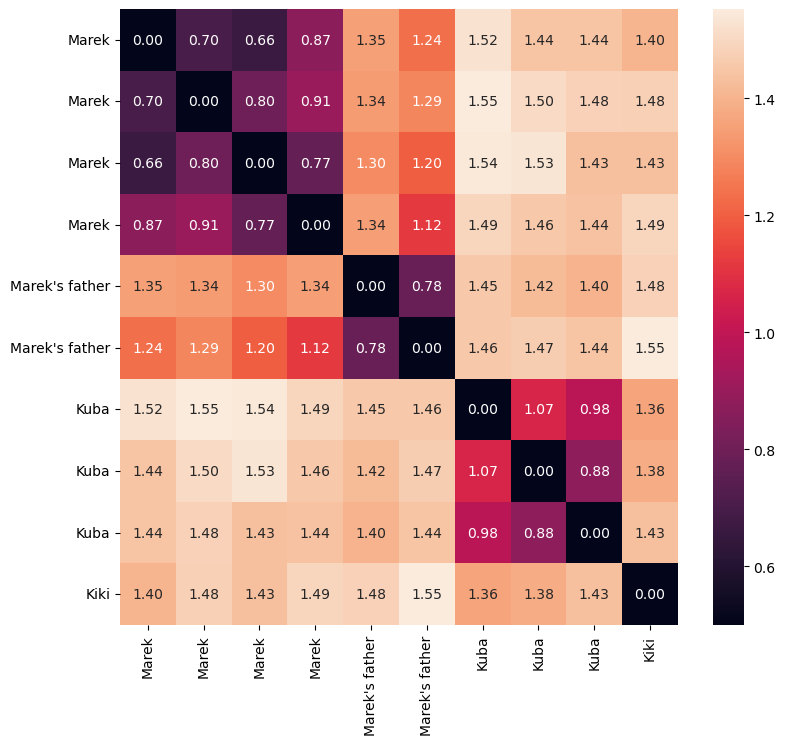

In [16]:
# get distances between the faces encoded in the feature space
# chceme zjistit, zda je na obrázku marek, takže malé hodnoty naznačují, je to marek a velké, že to není a na y ose máme, kdo to skutečně je


distances = pd.DataFrame(columns=images, index = images)

for img1 in images:
    for img2 in images:
        distances.loc[img1, img2] = np.linalg.norm(np.array(feat_space[img1]) - np.array(feat_space[img2]))
        
distances = distances.astype(float)

plt.figure(figsize=(9,8))
sns.heatmap(distances, annot=True, fmt='.2f', vmin=0.5, xticklabels=list(images.values()), yticklabels=list(images.values()))
plt.show()

In [17]:
# put in into numpy array

dt = np.ndarray(shape=(len(feat_space),len(feat_space['face1.jpg'])))
i = 0
for img, fs in feat_space.items():
    dt[i, :] = fs
    i += 1

In [18]:
# apply PCA - analýza hlavních komponent fot display the distance in 2D

from sklearn.decomposition import PCA
import bokeh.plotting as bp
from bokeh.models import HoverTool
from bokeh.plotting import show, output_notebook


# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width = 700, plot_height = 600, title="Face feature space",
    tools="pan,reset,hover",
    x_axis_type = None, y_axis_type = None, min_border = 1)

# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components = 2)
pca_enc = pca.fit(dt).transform(dt)

# putting everything in a dataframe
pca_df = pd.DataFrame(pca_enc, columns=['x', 'y'])
pca_df['person'] = list(images.values())

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x = 'x', y = 'y', source = pca_df)
hover = plot_tfidf.select(dict(type = HoverTool))
hover.tooltips = {"person": "@person"}
show(plot_tfidf)

Loading BokehJS ...

<span style="color:red">**TO DO:** Get your own photos or download some from the internet. Try to think of some interesting combinations, circumstances etc. What distance threshold would you choose to consider 2 faces to belong to the same person?</span>
